<a href="https://colab.research.google.com/github/Dk093/AI/blob/main/Image_Segmentation_of_CAMVID_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cityscape Analysis using Image Segmentation**

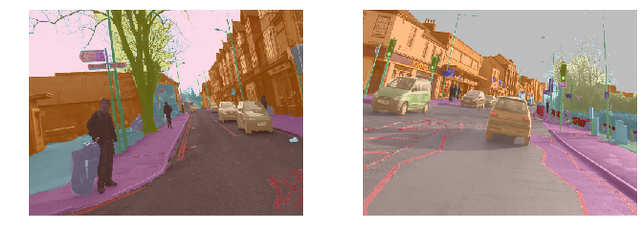

In computer vision, Image segmentation is an application wherein we color-code every pixel in an image. Each pixel value then represents a particular object in that image. For instance, we can see in the above images that every building has the same color.

This project aims to color-code the images in **CAMVID** dataset according to the given color-codes.

## Image segmentation with CamVid





The lines in notebook that starts with ‘**%**’ are called Line Magics.

The **reload_ext** autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.

The next line **autoreload** 2 imports all modules before executing the typed code.

The next line is to plot the graphs inside the jupyter notebook. We use matplotlib inline.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

First we import the necessary libraries from **fastai** package.

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Fastai provides a lot of academic datasets under **URLs**. So we use the function **untar_data()** with **URLs.CAMVID** as input to download the dataset.

In [ ]:
path = untar_data(URLs.CAMVID)


Then we use **ls()** function which returns the list of file names and directories in the path specified.

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

We can see that there is **labels** folder containing the color-coded images and **images** folder containing the actual images.

Now we will create paths for labels and images.

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

To take a look at the images , we will first get the file names of the images in **images** and **labels** folders using **get_image_files()** function of **fastai** library.

In [ ]:
image_names = get_image_files(path_img)
image_names[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009000.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02220.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07620.png')]

In [ ]:
label_names = get_image_files(path_lbl)
label_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00540_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_00810_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01860_P.png')]

We can see the images are in png format and every label file is ending with **_P**.

##Exploratory Data Analysis

To open an image we will select an element(image path of a certain image) from **image_names[ ]** and use function **open_image()** with the image path as the input and then using **show()** function to view the image.

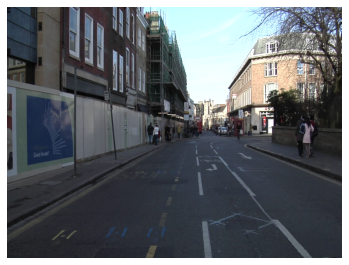

In [ ]:
img_f = image_names[3]
img = open_image(img_f)
img.show(figsize=(6,6))

The filenames of the actual images and the labelled images are the same except, the corresponding labelled image has a **_P** towards the end. So we will write a **lambda** function **get_lbl_img** which for every image, identifies its corresponding labelled counterpart.

In [ ]:
get_lbl_img = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Standard images are the collection of floats which represent the pixel value at each point. But label images may consist of numbers, but those numbers do not represent the pixel values. Those numbers are codes which represent the various classified object in the image. Thus to see the image labels, we will use **open_mask()** which plays the same role as **open_image()**.

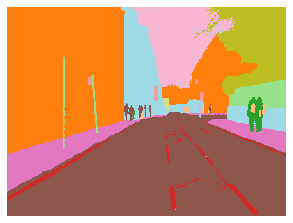

In [ ]:
mask = open_mask(get_lbl_img(img_f))
mask.show(figsize=(5,5), alpha=1)

Now using data attribute, we can check in which format the image is saved.

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

We will load the **codes** file to see its contents which are different objects that might be present in an image and for which we have to color code the images for segmentation.

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

To understand how the images are color-coded, we can see that the labelled data(**mask.data**) had a lot of **17s** in it. Counting from index 0 in our codes file we see that the object referred by the integer 17 is a **Road**. So these values correspond to the road in the image.


## Creating Databunch

Now that we’ve understood our data, we can move on to creating a data bunch and training our model. We will create a **databunch** using fastai **data block** API.

Batch size is the number of images to be processed at a time. The value may vary like 8, 16, .., 64,.. depending upon the GPU configuration. Since classifying every pixel in every image is a resource-intensive task, we will not use the whole dataset, and we will also keep the batch size relatively small.

In [ ]:
size = src_size//2
bs=4

We will be using **SegmentationItemList** because of the type of inputs with us.
The different functions used for the following reasons 
*   **.from_folder(path_img)** : our image data is present at the specified path.
*   **.split_by_fname_file()** : Split the data into training and testing datasets based on the file names mentioned in **valid.txt**.
*   **get_lbl_img()** : Find the labelled images using the lambda function **get_lbl_img()** and use the codes as **classes** to be predicted.





In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_lbl_img, classes=codes))

Then to make the **databunch** we take the **size** and **bs**(batch size) as defined earlier by us. Also ,note that the **tfm_y = True**. This means that whatever transform we apply on our dependent images should also be applied to our target image. (Example: If we flip an image vertically, we should also flip the corresponding labelled image).


In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

We will use **show_batch()** function to view the images in the databunch.

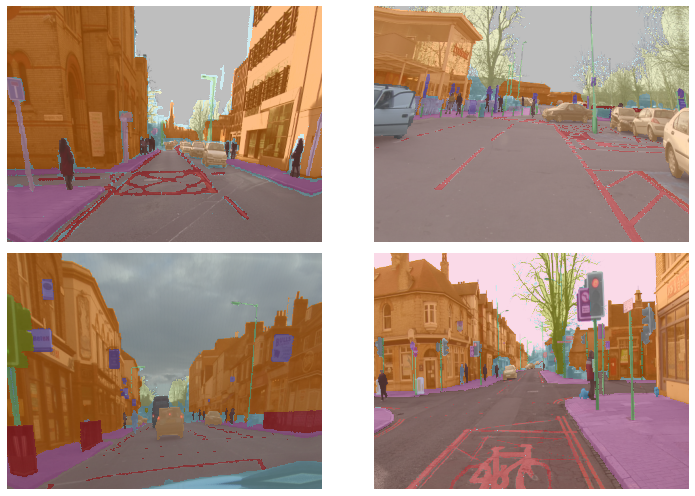

In [ ]:
data.show_batch(9, figsize=(11,7))

## Training the Model

The accuracy in an image segmentation problem is the same as that in any classification problem.

   **Accuracy = no. of correctly classified pixels/total no. of pixels**




But in this dataset, some pixels are labelled as **Void** (this label also exists in **codes.txt**) and shouldn’t be considered while calculating the accuracy. Hence we define a new function **acc_camvid()** for accuracy where we avoid these labels.

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid

We always set the value of weight decay **(wd)** between 0 to 1 as by using this, we penalize the weights of the network to avoid **over-fitting**(when the model fits the training data too well and thus perform poorly on additional data).

In [ ]:
wd=1e-2

For training the model, we will use a CNN(convolution neural network) architecture called **U-Net** since they are good at recreating images. And we will use a **resnet34** architecture for our model with metrics set as **acc_camvid**.

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

We will use **fit_one_cycle()** function with **epoch** value 2 to train the model. The epoch value indicates the number of passes of the entire training dataset is made to pass through our network while training the model.

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.086749,1.496661,0.597637,1:45:40
1,0.983721,0.834485,0.800333,1:46:03


We can see that the accuracy of our model that we defined as **acc_camvid** has reached 80% in just 2 **epochs**. We could have used higher value for epochs but it takes a lot of time to complete one epoch(around 2hours)

Now we will save our model using **save()** function in case we run out of memory.
And we can use **load()** function to load a model at a specific stage. We can also see the full CNN architecture of our model using  **load()**.

In [ ]:
learn.save('stage-1')
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

We can see the comparison between the actual images and the predicted images by using **learn.show_results()**.

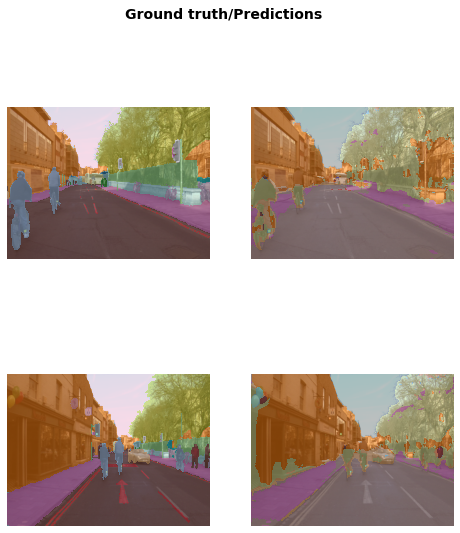

In [ ]:
learn.show_results(rows=2, figsize=(8,9))

Once we have trained the model, now we can increase the accuracy of the model by fine-tuning it.

# Fine Tuning the Model

**Learning rate** is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving towards a minimum of a loss function.

To fine-tune the model, we need to find an optimum learning rate for training the model. We can find this by using a learning rate finder **lr_find**. It will do a mock training by going over a large range of learning rates, then plot them against the losses. We will pick a value a bit before the minimum, where the loss still improves. Our graph would look something like this:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


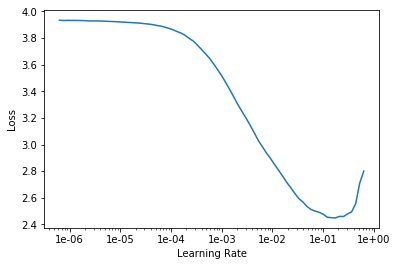

In [ ]:
lr_find(learn)
learn.recorder.plot()

By looking at the graph we choose an optimal learning rate(**lr**). 

In [ ]:
lr=3e-3

Now, we will again train our model using **fit_one_cycle()** with epoch value 2 and pass **lr** as the learning rate. We will also set **pct_start** to 0.9 which is the percentage of overall iterations where the learning rate is increasing. We will use **unfreeze()** function first to unfreeze the layers of the model else we will not be able to train the frozen weights of our model.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.172738,0.771233,0.820753
2,0.799105,0.637969,0.825231
3,0.731867,0.628517,0.824456
4,0.630086,0.486045,0.860029
5,0.616145,0.535374,0.860695
6,0.588540,0.439988,0.879501
7,0.551265,0.412592,0.884478
8,0.568172,0.679087,0.832221
9,0.538392,0.405911,0.879605
10,0.451235,0.353972,0.892891


As we can see, the **accuracy** of the model is increased up to **89%** by fine-tuning the model.
We can further improve our model by finding a new optimum learning rate and then again training the model.

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2');

By using **show_results()** function, we can see that the quality of predictions has also improved with improved **acc_camvid**.

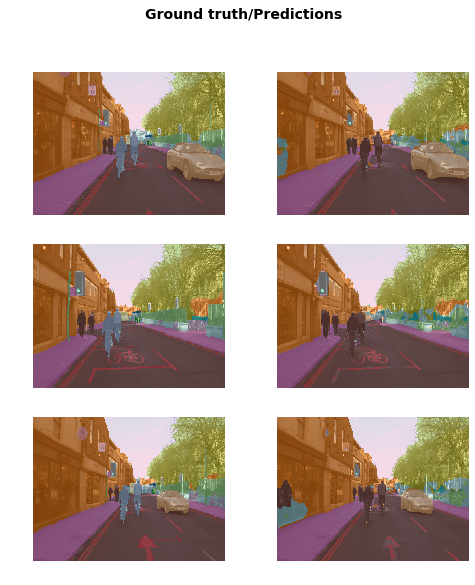

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

# Deployment


For deployment, the following details should be kept in mind:
- On an Nvidia P4 16Gb GPU, it took roughly 2 hours to finish running 1 epoch of training. To achieve 80% accuracy, the model needs to be trained for at least 2 epochs. 
- The only pre-requisite library is **fastai**.